In [68]:
#Importing all the necessary modules
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

In [39]:
df = pd.read_csv("./data.csv")

# 1. Exploratory Data Analysis
## 1.1 Summary

To make the summary more readible, let's measure weekly sales in thousands.

In [40]:
# Checking the first few rows of the dataset.
print(df.head())

   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  




**Description of the Columns:**

*Store*: the number of the store (ID).

*Date*: the week of sales.

*Weekly_Sales*: the weekly sales for the given store.

*Holiday_Flag*: whether the week is a special holiday week or not (1 = holiday week; 0 = non-holiday week).

*Temperature*: an average temperature in the region for the given week.

*Fuel_Price*: cost of fuel in the region for the given week.

*CPI*: the consumer price index for the given week.

*Unemployment*: the unemployment rate for the region for the given week.


In [41]:
# Checking for missing values.
print(df.isnull().sum())

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [42]:
#Getting basic statistics for every column except for the ID column.
df.iloc[:, 1:].describe()

,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


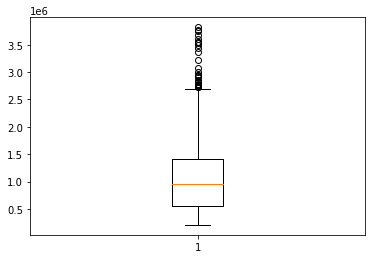

In [43]:
# Checking for outliers or unusual observations in the data
plt.boxplot(df['Weekly_Sales'])
plt.show()

The presence of numerous outliers in the data, as depicted by the boxplot, diminishes the effectiveness of the mean as a representative measure. In such cases, it is advisable to utilize a more robust measure of central tendency, such as the trimmed mean. Unlike the mean, which can be heavily influenced by extreme values, the trimmed mean mitigates the impact of outliers by excluding a predetermined proportion of the highest and lowest values from the calculation. By employing the trimmed mean, a more reliable estimate of the central tendency can be obtained, providing a better reflection of the underlying data distribution.

In [44]:
trimMean = stats.trim_mean(df['Weekly_Sales'], 0.1)
print(trimMean)
mean = df.iloc[:, 2].mean()
print(round((trimMean - mean)/mean, 2))

1004198.3322567489
-0.04


After leaving out the outliers (top and bottom 10%), the mean is smaller by 4%.

## 1. 2 Correlation

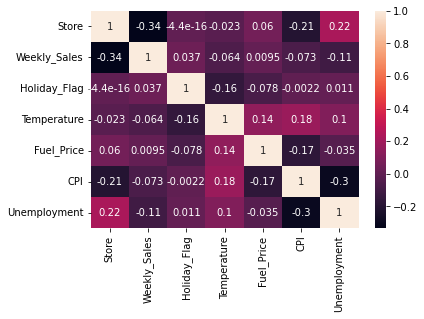

In [45]:
# Visualizing the correlation between variables to find useful relations between variables.
sns.heatmap(df.corr(), annot=True)
plt.show()

#### Results

1. The highest correlation of 0.34 between stores and sales suggests that there may be additional factors not included in the analysis that influence sales. Potential factors could include store size, population density in the surrounding area, location, and customer income levels.

2. The second largest correlation of -0.3 between CPI (Consumer Price Index) and unemployment aligns with the economic theory known as the Phillips curve. The Phillips curve suggests an inverse relationship between inflation (as measured by CPI) and unemployment, indicating that as one increases, the other decreases.

3. Upon initial inspection, there appear to be no strong relationships between variables. However, further analysis and examination of additional variables may be necessary to uncover any hidden or subtle correlations that were not immediately apparent.

# 2. Sales Analysis

## 2.1. Seasonality
A thorough decomposition analysis of the data will be conducted to assess the presence of seasonal patterns. Valuable insights into the dataset's seasonal components and their influence on overall behavior will be obtained through this systematic and methodical approach.

In [46]:
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [47]:
weeklySales = df.groupby(['Date'])['Weekly_Sales'].sum().reset_index()

In [48]:
print(weeklySales)

          Date  Weekly_Sales
0   2010-02-05   49750740.50
1   2010-02-12   48336677.63
2   2010-02-19   48276993.78
3   2010-02-26   43968571.13
4   2010-03-05   46871470.30
..         ...           ...
138 2012-09-28   43734899.40
139 2012-10-05   47566639.31
140 2012-10-12   46128514.25
141 2012-10-19   45122410.57
142 2012-10-26   45544116.29

[143 rows x 2 columns]


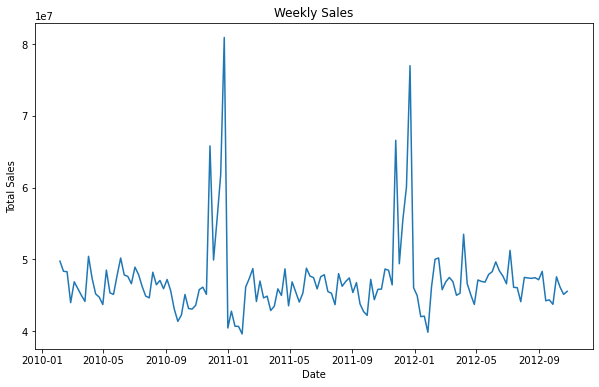

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(weeklySales.iloc[:, 0], weeklySales.iloc[:, 1])
plt.title('Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

The analysis of the data indicates the presence of seasonality, suggesting that the observations exhibit recurring patterns within specific time intervals. 

In [50]:
print(weeklySales.sort_values('Weekly_Sales', ascending = False))

          Date  Weekly_Sales
46  2010-12-24   80931415.60
98  2011-12-23   76998241.31
94  2011-11-25   66593605.26
42  2010-11-26   65821003.24
45  2010-12-17   61820799.85
..         ...           ...
49  2011-01-14   40673678.04
50  2011-01-21   40654648.03
47  2010-12-31   40432519.00
103 2012-01-27   39834974.67
51  2011-01-28   39599852.99

[143 rows x 2 columns]


Upon analyzing the sales data, a notable observation is the peak sales occurring during the Christmas period. This aligns with the presence of significant and influential seasonality, as evident from the graphical representation.

## 2.2. Stationarity

The next step will involve the assessment of stationarity using the ADF Test, which will be employed for this purpose. In order to conduct the test, it will be necessary to eliminate the influence of seasonality from the data.

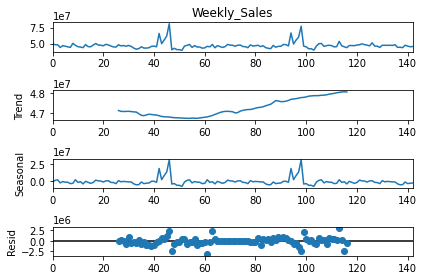

In [60]:
decomposition = seasonal_decompose(weeklySales['Weekly_Sales'], model='additive', period=52)
deseason = weeklySales.copy()
deseason['Weekly_Sales'] =  deseason['Weekly_Sales'] - decomposition.seasonal
decomposition.plot()
plt.show()

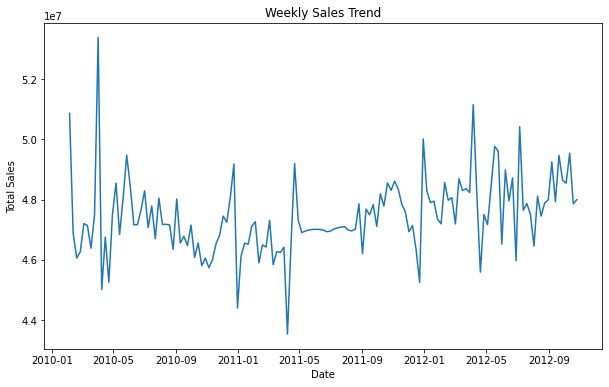

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(deseason.iloc[:, 0], deseason.iloc[:, 1])
plt.title('Weekly Sales Trend')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

In [65]:
dftest = adfuller(deseason['Weekly_Sales'], autolag = 'AIC')
print("ADF : ",dftest[0])
print("P-Value : ", dftest[1])
print("Num Of Lags : ", dftest[2])

ADF :  -3.988472600024742
P-Value :  0.00147208959475911
Num Of Lags :  3


A p-value of 0.001 in the Augmented Dickey-Fuller (ADF) test indicates that there is strong evidence to reject the null hypothesis of non-stationarity. The null hypothesis of the ADF test is that the time series has a unit root, meaning it is non-stationary. However, with a p-value of 0.001, which is less than the conventional significance level of 0.05 (or even 0.01), there is sufficient statistical evidence to conclude that the time series is stationary.

## 2.3. Autocorrelation

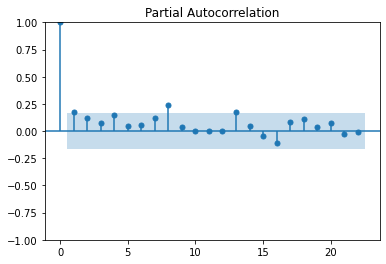

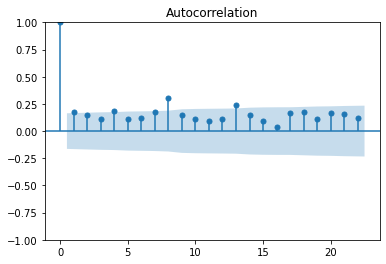

In [70]:
plot_pacf(deseason['Weekly_Sales'], method='ywm');
plot_acf(deseason['Weekly_Sales']);